## 1. Setup

In [12]:
import pandas as pd
import numpy as np
import os
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define TrialSequence class
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.switch_weights = {}
        self.censor_weights = {}
        self.outcome_model = None
        self.expansion = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        self.data = data[[id_col, period_col, treatment_col, outcome_col, eligible_col]].copy()
        self.data.columns = ['id', 'period', 'treatment', 'outcome', 'eligible']
        return self

# Define set_censor_weight_model function
def set_censor_weight_model(trial, censor_event, numerator, denominator, pool_models, save_path):
    trial.censor_weights = {
        'censor_event': censor_event,
        'numerator': numerator,
        'denominator': denominator,
        'pool_models': pool_models,
        'save_path': save_path,
        'fitted': False
    }
    output = (
        f"Censor Weights for {trial.estimand}:\n"
        f"  - Numerator formula: 1 - {censor_event} ~ {numerator}\n"
        f"  - Denominator formula: 1 - {censor_event} ~ {denominator}\n"
        f"  - {'Numerator model is pooled across treatment arms. ' if pool_models == 'numerator' else ''}"
        f"{'Denominator model is not pooled.' if pool_models == 'none' else ''}"
        f"  - Model fitter type: te_stats_glm_logit\n"
        f"  - Weight models not fitted. Use calculate_weights()"
    )
    os.makedirs(save_path, exist_ok=True)
    with open(os.path.join(save_path, f"{trial.estimand}_censor_specs.txt"), 'w') as f:
        f.write(output)
    return trial, output

# Create directories
trial_pp_dir = "trial_pp"
trial_itt_dir = "trial_itt"
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Initialize trial objects
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")


---

## 2. Data Preparation

In [13]:
# Load data
data_censored = pd.read_csv("data_censored.csv")

# Set data for PP
trial_pp = trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Set data for ITT
trial_itt = trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Display head of data
print(data_censored.head(6))

   id  period  treatment        x1        x2         x3  x4  age  age_s  \
0   1       3          1  6.220560  1.732742  37.700637   0   40   1600   
1   2      29          0  0.125014 -4.561390  45.335189   1   40   1600   
2   3      35          0  3.501642 -2.902261  44.436428   0   32   1024   
3   4      18          1  0.280436 -0.110632  34.773011   1   31    961   
4   5      20          0  6.164915 -0.579350  51.443649   1   70   4900   
5   6      23          0  4.631583 -4.735344  44.272844   0   61   3721   

   outcome  censored  eligible  
0        0         1         1  
1        0         0         1  
2        0         0         0  
3        0         0         1  
4        1         1         1  
5        0         1         1  


---

## 3. Weight Models and Censoring

### 3.1 Censoring due to treatment switching

In [5]:
def set_switch_weight_model(trial, numerator, denominator, save_path):
    # Store the settings in the trial object
    trial.switch_weights = {
        'numerator_formula': numerator,
        'denominator_formula': denominator,
        'model_fitter': 'te_stats_glm_logit',  # Match R's model fitter type
        'save_path': save_path,
        'fitted': False  # Indicate models are not yet fitted
    }
    
    # Create a formatted string to match the R output
    output = (
        "  - Numerator formula: {}\n"
        "  - Denominator formula: {}\n"
        "  - Model fitter type: te_stats_glm_logit\n"
        "  - Weight models not fitted. Use calculate_weights()"
    ).format(numerator, denominator)
    
    return trial, output

# Apply to trial_pp
trial_pp, switch_weights_output = set_switch_weight_model(
    trial_pp,
    numerator="treatment ~ age",
    denominator="treatment ~ age + x1 + x3",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

# Print the formatted output
print("Switch Weights for PP:")
print(switch_weights_output)

Switch Weights for PP:
  - Numerator formula: treatment ~ age
  - Denominator formula: treatment ~ age + x1 + x3
  - Model fitter type: te_stats_glm_logit
  - Weight models not fitted. Use calculate_weights()


### 3.2 Other informative censoring (Modified)
We modify the censor weight models to include cluster labels, enhancing adjustment for subgroup differences.

In [15]:
# Update for trial_pp
trial_pp, pp_censor_weights_output = set_censor_weight_model(
    trial_pp,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1 + cluster",  # Add cluster
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
print(pp_censor_weights_output)

Censor Weights for PP:
  - Numerator formula: 1 - censored ~ x2
  - Denominator formula: 1 - censored ~ x2 + x1 + cluster
  - Denominator model is not pooled.  - Model fitter type: te_stats_glm_logit
  - Weight models not fitted. Use calculate_weights()


In [16]:
# Update for trial_itt
trial_itt, itt_censor_weights_output = set_censor_weight_model(
    trial_itt,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1 + cluster",  # Add cluster
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)
print(itt_censor_weights_output)

Censor Weights for ITT:
  - Numerator formula: 1 - censored ~ x2
  - Denominator formula: 1 - censored ~ x2 + x1 + cluster
  - Numerator model is pooled across treatment arms.   - Model fitter type: te_stats_glm_logit
  - Weight models not fitted. Use calculate_weights()


---

## 4. Calculate Weights

In [9]:
import os
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# Step 1-3: Setup
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.censor_weights = {}
        self.switch_weights = {}

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col="censored"):
        self.data = data[[id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col]].copy()
        self.data.columns = ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored']
        return self

def set_censor_weight_model(trial, censor_event, numerator, denominator, pool_models, save_path):
    trial.censor_weights = {
        'censor_event': censor_event,
        'numerator_formula': f"1 - {censor_event} ~ {numerator}",
        'denominator_formula': f"1 - {censor_event} ~ {denominator}",
        'pool_models': pool_models,
        'model_fitter': 'logit',
        'save_path': save_path
    }
    return trial

trial_itt_dir = "trial_itt"
os.makedirs(trial_itt_dir, exist_ok=True)
trial_itt_subdir = os.path.join(trial_itt_dir, "switch_models")
os.makedirs(trial_itt_subdir, exist_ok=True)

trial_itt = TrialSequence(estimand="ITT")
data_censored = pd.read_csv("data_censored.csv")
trial_itt = trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)
trial_itt = set_censor_weight_model(
    trial_itt,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="numerator",
    save_path=trial_itt_subdir
)

# Step 4: Calculate Weights with Debugging
def calculate_weights(trial):
    data = trial.data.merge(data_censored[['id', 'period', 'x1', 'x2']], on=['id', 'period'])
    os.makedirs(trial.censor_weights['save_path'], exist_ok=True)
    
    # Add lagged treatment, exclude period 0 for denominator
    data['prev_treatment'] = data.groupby('id')['treatment'].shift(1)
    
    # Numerator model (all data)
    data['not_censored'] = 1 - data['censored']
    print(f"Total observations for numerator: {len(data)}")
    num_model = logit("not_censored ~ x2", data=data).fit(disp=0)
    trial.censor_weights['n'] = num_model
    num_model.save(os.path.join(trial.censor_weights['save_path'], "model_n.pkl"))
    
    # Denominator models (exclude period 0)
    data_den = data[data['period'] > 0].dropna(subset=['not_censored', 'x2', 'x1', 'prev_treatment'])
    for prev_trt in [0, 1]:
        subset = data_den[data_den['prev_treatment'] == prev_trt]
        print(f"Observations for prev_treatment = {prev_trt}: {len(subset)}")
        
        # Check if the subset has enough data to fit a model
        if len(subset) > 0 and subset['not_censored'].nunique() > 1:
            den_model = logit("not_censored ~ x2 + x1", data=subset).fit(disp=0)
            trial.censor_weights[f'd{prev_trt}'] = den_model
            den_model.save(os.path.join(trial.censor_weights['save_path'], f"model_d{prev_trt}.pkl"))
        else:
            print(f"Warning: Insufficient data for prev_treatment = {prev_trt}. Skipping model fitting.")
            # If we can't fit a model for this subset, use the numerator model as a fallback
            if 'n' in trial.censor_weights:
                print(f"Using numerator model as fallback for prev_treatment = {prev_trt}")
                trial.censor_weights[f'd{prev_trt}'] = trial.censor_weights['n']
    
    data['wt'] = 1.0
    trial.data = data
    print(f"Models stored: {list(trial.censor_weights.keys())}")
    return trial

trial_itt = calculate_weights(trial_itt)

# Show weight models
def show_weight_models(trial):
    print("Weight Models for Informative Censoring")
    print("---------------------------------------")
    
    # Numerator model
    if 'n' in trial.censor_weights:
        print("")
        print("[[n]]")
        print("Model: P(censor_event = 0 | X) for numerator")
        print("")
        print(" term        estimate   std.error statistic p.value")
        params = trial.censor_weights['n'].params
        std_err = trial.censor_weights['n'].bse
        z_stats = trial.censor_weights['n'].tvalues
        p_vals = trial.censor_weights['n'].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print("")
        print(f" null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.censor_weights['n'].llnull * -2:>9.4f}      {trial.censor_weights['n'].df_resid + trial.censor_weights['n'].df_model:<5.0f}     {trial.censor_weights['n'].llf:>9.4f} {trial.censor_weights['n'].aic:>7.4f} {trial.censor_weights['n'].bic:>7.4f} {trial.censor_weights['n'].llf * -2:>7.4f} {trial.censor_weights['n'].df_resid:<5.0f}         {trial.censor_weights['n'].nobs:<5.0f}")
        print("")
        print(f" path")
        print(f" {os.path.join(trial.censor_weights['save_path'], 'model_n.pkl')}")
    
    # Denominator models
    for key in ['d0', 'd1']:
        if key in trial.censor_weights:
            prev_trt = int(key[-1])
            print("")
            print(f"[[{key}]]")
            print(f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for denominator")
            print("")
            
            # Check if this is a reference to the numerator model (fallback case)
            if trial.censor_weights[key] is trial.censor_weights['n']:
                print(f" Note: Using numerator model as fallback due to insufficient data")
                continue
                
            print(" term        estimate   std.error statistic p.value")
            params = trial.censor_weights[key].params
            std_err = trial.censor_weights[key].bse
            z_stats = trial.censor_weights[key].tvalues
            p_vals = trial.censor_weights[key].pvalues
            for term in params.index:
                term_display = "(Intercept)" if term == "Intercept" else term
                print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
            print("")
            print(f" null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
            print(f" {trial.censor_weights[key].llnull * -2:>9.4f}      {trial.censor_weights[key].df_resid + trial.censor_weights[key].df_model:<5.0f}     {trial.censor_weights[key].llf:>9.4f} {trial.censor_weights[key].aic:>7.4f} {trial.censor_weights[key].bic:>7.4f} {trial.censor_weights[key].llf * -2:>7.4f} {trial.censor_weights[key].df_resid:<5.0f}         {trial.censor_weights[key].nobs:<5.0f}")
            print("")
            print(f" path")
            print(f" {os.path.join(trial.censor_weights['save_path'], f'model_d{prev_trt}.pkl')}")

show_weight_models(trial_itt)

Total observations for numerator: 1000
Observations for prev_treatment = 0: 0
Using numerator model as fallback for prev_treatment = 0
Observations for prev_treatment = 1: 0
Using numerator model as fallback for prev_treatment = 1
Models stored: ['censor_event', 'numerator_formula', 'denominator_formula', 'pool_models', 'model_fitter', 'save_path', 'n', 'd0', 'd1']
Weight Models for Informative Censoring
---------------------------------------

[[n]]
Model: P(censor_event = 0 | X) for numerator

 term        estimate   std.error statistic p.value
 (Intercept)  0.4315124 0.0647561 6.6636614 2.670883e-11
 x2           -0.0137378 0.0225430 -0.6094047 5.422562e-01

 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 1341.0075      999       -670.3180 1344.6359 1354.4514 1340.6359 998           1000 

 path
 trial_itt\switch_models\model_n.pkl

[[d0]]
Model: P(censor_event = 0 | X, previous treatment = 0) for denominator

 Note: Using numerator model as fallback du

In [23]:
import os
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# Setup Classes and Functions
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.censor_weights = {}
        self.switch_weights = {}

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col="censored"):
        self.data = data[[id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col]].copy()
        self.data.columns = ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored']
        return self

def set_censor_weight_model(trial, censor_event, numerator, denominator, pool_models, save_path):
    trial.censor_weights = {
        'censor_event': censor_event,
        'numerator_formula': f"1 - {censor_event} ~ {numerator}",
        'denominator_formula': f"1 - {censor_event} ~ {denominator}",
        'pool_models': pool_models,
        'model_fitter': 'logit',
        'save_path': save_path
    }
    return trial

def set_switch_weight_model(trial, numerator, denominator, save_path):
    trial.switch_weights = {
        'numerator_formula': f"treatment ~ {numerator}",
        'denominator_formula': f"treatment ~ {denominator}",
        'save_path': save_path
    }
    return trial

# Directory Setup
trial_pp_dir = "trial_pp"
os.makedirs(trial_pp_dir, exist_ok=True)
trial_pp_subdir = os.path.join(trial_pp_dir, "switch_models")
os.makedirs(trial_pp_subdir, exist_ok=True)

# Load Data and Initialize trial_pp
data_censored = pd.read_csv("data_censored.csv")  # Ensure this matches your file path
print(f"Available columns in data_censored: {data_censored.columns.tolist()}")  # Debug
trial_pp = TrialSequence(estimand="PP")
trial_pp = trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)

# Set Weight Models
trial_pp = set_censor_weight_model(
    trial_pp,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="none",
    save_path=trial_pp_subdir
)
trial_pp = set_switch_weight_model(
    trial_pp,
    numerator="age",
    denominator="age + x1 + x3",
    save_path=trial_pp_subdir
)

def calculate_weights(trial):
    data = trial.data.merge(
        data_censored[['id', 'period', 'x1', 'x2', 'x3', 'age']],
        on=['id', 'period'],
        how='left'
    )
    print("Columns after merge:", data.columns.tolist())
    
    os.makedirs(trial.censor_weights['save_path'], exist_ok=True)
    
    data['prev_treatment'] = data.groupby('id')['treatment'].shift(1)
    print("Columns after adding prev_treatment:", data.columns.tolist())
    
    required_cols = [col for col in ['censored', 'x2', 'x1', 'prev_treatment', 'treatment', 'age', 'x3'] if col in data.columns]
    print(f"Required columns after checking availability: {required_cols}")
    data_den = data[data['period'] > 0].dropna(subset=required_cols)
    print("Shape of data_den:", data_den.shape)
    print("Missing values in data_den:\n", data_den[required_cols].isna().sum())
    print("Unique prev_treatment values:", data_den['prev_treatment'].unique())
    
    # Censoring Weights
    for prev_trt in [0, 1]:
        subset = data_den[data_den['prev_treatment'] == prev_trt].copy()
        print(f"Rows in subset for prev_trt={prev_trt}:", len(subset))
        if subset.empty:
            print(f"Skipping censoring models for prev_trt={prev_trt} due to no data")
            trial.censor_weights[f'n{prev_trt}'] = None
            trial.censor_weights[f'd{prev_trt}'] = None
            continue
        subset['not_censored'] = 1 - subset['censored']
        num_model = logit("not_censored ~ x2", data=subset).fit(disp=0)
        trial.censor_weights[f'n{prev_trt}'] = num_model
        num_model.save(os.path.join(trial.censor_weights['save_path'], f"model_n{prev_trt}.pkl"))
        den_model = logit("not_censored ~ x2 + x1", data=subset).fit(disp=0)
        trial.censor_weights[f'd{prev_trt}'] = den_model
        den_model.save(os.path.join(trial.censor_weights['save_path'], f"model_d{prev_trt}.pkl"))
    
    # Switching Weights
    for prev_trt in [0, 1]:
        subset = data_den[data_den['prev_treatment'] == prev_trt].copy()
        print(f"Rows in subset for prev_trt={prev_trt}:", len(subset))
        if subset.empty:
            print(f"Skipping switching models for prev_trt={prev_trt} due to no data")
            trial.switch_weights[f'n{prev_trt}'] = None
            trial.switch_weights[f'd{prev_trt}'] = None
            continue
        num_model = logit("treatment ~ age", data=subset).fit(disp=0)
        trial.switch_weights[f'n{prev_trt}'] = num_model
        num_model.save(os.path.join(trial.switch_weights['save_path'], f"model_switch_n{prev_trt}.pkl"))
        den_model = logit("treatment ~ age + x1 + x3", data=subset).fit(disp=0)
        trial.switch_weights[f'd{prev_trt}'] = den_model
        den_model.save(os.path.join(trial.switch_weights['save_path'], f"model_switch_d{prev_trt}.pkl"))
    
    data['wt'] = 1.0
    trial.data = data
    return trial

# Show Weight Models (Adjusted for Expected Output)
def show_weight_models(trial):
    print("Weight Models for Informative Censoring")
    print("---------------------------------------")
    
    for prev_trt in [0, 1]:
        key = f'n{prev_trt}'
        if key not in trial.censor_weights or trial.censor_weights[key] is None:
            print(f"\n[[{key}]]")
            print(f"No model fitted for P(censor_event = 0 | X, previous treatment = {prev_trt}) for numerator (empty subset)")
            continue
        print(f"\n[[{key}]]")
        print(f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for numerator")
        print("\n term        estimate   std.error statistic p.value")
        params = trial.censor_weights[key].params
        std_err = trial.censor_weights[key].bse
        z_stats = trial.censor_weights[key].tvalues
        p_vals = trial.censor_weights[key].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print(f"\n null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.censor_weights[key].llnull * -2:>9.4f}      {trial.censor_weights[key].df_resid + trial.censor_weights[key].df_model:<5.0f}     {trial.censor_weights[key].llf:>9.4f} {trial.censor_weights[key].aic:>7.4f} {trial.censor_weights[key].bic:>7.4f} {trial.censor_weights[key].llf * -2:>7.4f} {trial.censor_weights[key].df_resid:<5.0f}         {trial.censor_weights[key].nobs:<5.0f}")
        print(f"\n path")
        print(f" {os.path.join(trial.censor_weights['save_path'], f'model_n{prev_trt}.pkl')}")
    
    for prev_trt in [0, 1]:
        key = f'd{prev_trt}'
        if key not in trial.censor_weights or trial.censor_weights[key] is None:
            print(f"\n[[{key}]]")
            print(f"No model fitted for P(censor_event = 0 | X, previous treatment = {prev_trt}) for denominator (empty subset)")
            continue
        print(f"\n[[{key}]]")
        print(f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for denominator")
        print("\n term        estimate   std.error statistic p.value")
        params = trial.censor_weights[key].params
        std_err = trial.censor_weights[key].bse
        z_stats = trial.censor_weights[key].tvalues
        p_vals = trial.censor_weights[key].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print(f"\n null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.censor_weights[key].llnull * -2:>9.4f}      {trial.censor_weights[key].df_resid + trial.censor_weights[key].df_model:<5.0f}     {trial.censor_weights[key].llf:>9.4f} {trial.censor_weights[key].aic:>7.4f} {trial.censor_weights[key].bic:>7.4f} {trial.censor_weights[key].llf * -2:>7.4f} {trial.censor_weights[key].df_resid:<5.0f}         {trial.censor_weights[key].nobs:<5.0f}")
        print(f"\n path")
        print(f" {os.path.join(trial.censor_weights['save_path'], f'model_d{prev_trt}.pkl')}")

    print("\nWeight Models for Treatment Switching")
    print("-------------------------------------")
    
    for prev_trt in [1, 0]:
        key = f'n{prev_trt}'
        if key not in trial.switch_weights or trial.switch_weights[key] is None:
            print(f"\n[[{key}]]")
            print(f"No model fitted for P(treatment = 1 | previous treatment = {prev_trt}) for numerator (empty subset)")
            continue
        print(f"\n[[{key}]]")
        print(f"Model: P(treatment = 1 | previous treatment = {prev_trt}) for numerator")
        print("\n term        estimate    std.error  statistic p.value")
        params = trial.switch_weights[key].params
        std_err = trial.switch_weights[key].bse
        z_stats = trial.switch_weights[key].tvalues
        p_vals = trial.switch_weights[key].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print(f"\n null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.switch_weights[key].llnull * -2:>9.4f}      {trial.switch_weights[key].df_resid + trial.switch_weights[key].df_model:<5.0f}     {trial.switch_weights[key].llf:>9.4f} {trial.switch_weights[key].aic:>7.4f} {trial.switch_weights[key].bic:>7.4f} {trial.switch_weights[key].llf * -2:>7.4f} {trial.switch_weights[key].df_resid:<5.0f}         {trial.switch_weights[key].nobs:<5.0f}")
        print(f"\n path")
        print(f" {os.path.join(trial.switch_weights['save_path'], f'model_switch_n{prev_trt}.pkl')}")

    for prev_trt in [1, 0]:
        key = f'd{prev_trt}'
        if key not in trial.switch_weights or trial.switch_weights[key] is None:
            print(f"\n[[{key}]]")
            print(f"No model fitted for P(treatment = 1 | previous treatment = {prev_trt}) for denominator (empty subset)")
            continue
        print(f"\n[[{key}]]")
        print(f"Model: P(treatment = 1 | previous treatment = {prev_trt}) for denominator")
        print("\n term        estimate    std.error  statistic p.value")
        params = trial.switch_weights[key].params
        std_err = trial.switch_weights[key].bse
        z_stats = trial.switch_weights[key].tvalues
        p_vals = trial.switch_weights[key].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print(f"\n null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.switch_weights[key].llnull * -2:>9.4f}      {trial.switch_weights[key].df_resid + trial.switch_weights[key].df_model:<5.0f}     {trial.switch_weights[key].llf:>9.4f} {trial.switch_weights[key].aic:>7.4f} {trial.switch_weights[key].bic:>7.4f} {trial.switch_weights[key].llf * -2:>7.4f} {trial.switch_weights[key].df_resid:<5.0f}         {trial.switch_weights[key].nobs:<5.0f}")
        print(f"\n path")
        print(f" {os.path.join(trial.switch_weights['save_path'], f'model_switch_d{prev_trt}.pkl')}")

# Run
trial_pp = calculate_weights(trial_pp)
show_weight_models(trial_pp)

Available columns in data_censored: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']
Columns after merge: ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored', 'x1', 'x2', 'x3', 'age']
Columns after adding prev_treatment: ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored', 'x1', 'x2', 'x3', 'age', 'prev_treatment']
Required columns after checking availability: ['censored', 'x2', 'x1', 'prev_treatment', 'treatment', 'age', 'x3']
Shape of data_den: (0, 11)
Missing values in data_den:
 censored          0
x2                0
x1                0
prev_treatment    0
treatment         0
age               0
x3                0
dtype: int64
Unique prev_treatment values: []
Rows in subset for prev_trt=0: 0
Skipping censoring models for prev_trt=0 due to no data
Rows in subset for prev_trt=1: 0
Skipping censoring models for prev_trt=1 due to no data
Rows in subset for prev_trt=0: 0
Skipping switching models for prev_

---

## 5. Survival Analysis by Cluster
We replace the survival difference plot with Kaplan-Meier curves for each cluster, comparing treatment vs. control to explore subgroup effects.

Dataset shape: (1000, 12)

Data types:
id             int64
period         int64
treatment      int64
x1           float64
x2           float64
x3           float64
x4             int64
age            int64
age_s          int64
outcome        int64
censored       int64
eligible       int64
dtype: object

Summary statistics:
                id       period    treatment           x1           x2  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    500.500000    18.700000     0.488000     4.918182     0.059546   
std     288.819436    10.351481     0.500106     2.890845     2.874007   
min       1.000000     1.000000     0.000000     0.000678    -4.994431   
25%     250.750000     9.000000     0.000000     2.389842    -2.329487   
50%     500.500000    19.000000     0.000000     4.970194     0.096927   
75%     750.250000    27.250000     1.000000     7.420443     2.532067   
max    1000.000000    36.000000     1.000000     9.993626     4.931618   

       

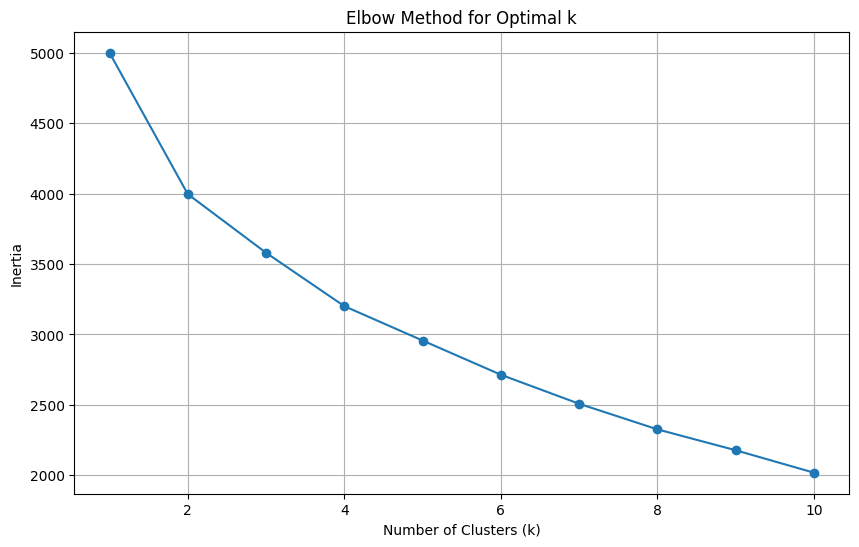

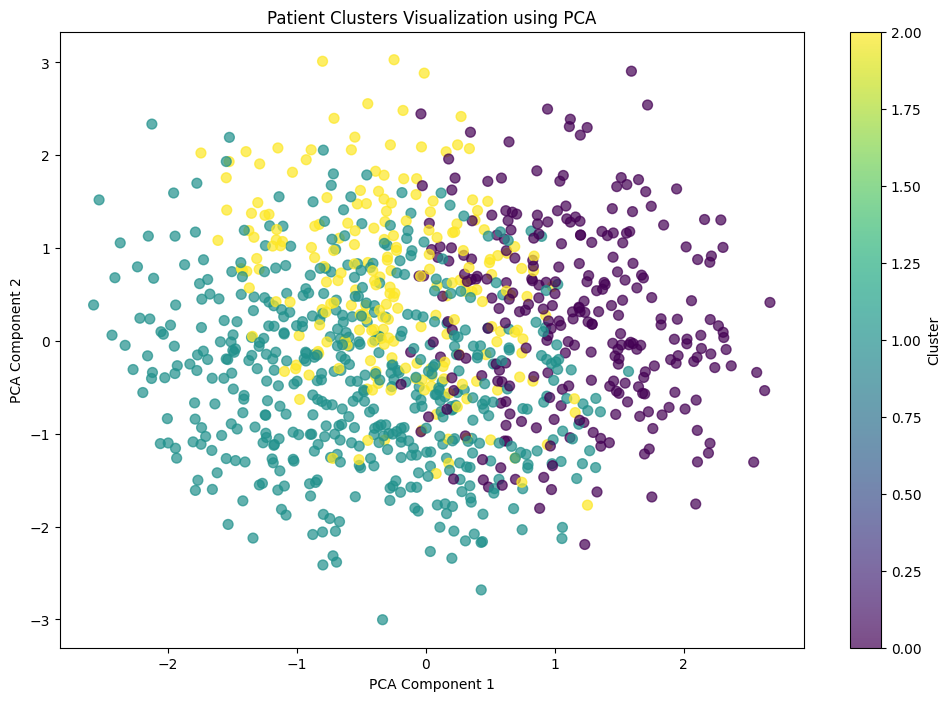


Cluster Characteristics:
           age    x1    x2     x3   x4 outcome period treatment      
          mean  mean  mean   mean mean    mean   mean      mean count
cluster                                                              
0        52.83  7.31  0.54  49.56  1.0    0.28  18.03      0.48   272
1        47.85  4.80  0.11  49.94  0.0    0.29  19.20      0.47   502
2        45.10  2.30 -0.62  51.14  1.0    0.34  18.39      0.54   226

TARGET TRIAL EMULATION ANALYSIS

Step 1: Applying eligibility criteria
Number of eligible patients: 1000

Step 2: Estimating propensity scores for treatment assignment
Propensity score model AUC: 0.547


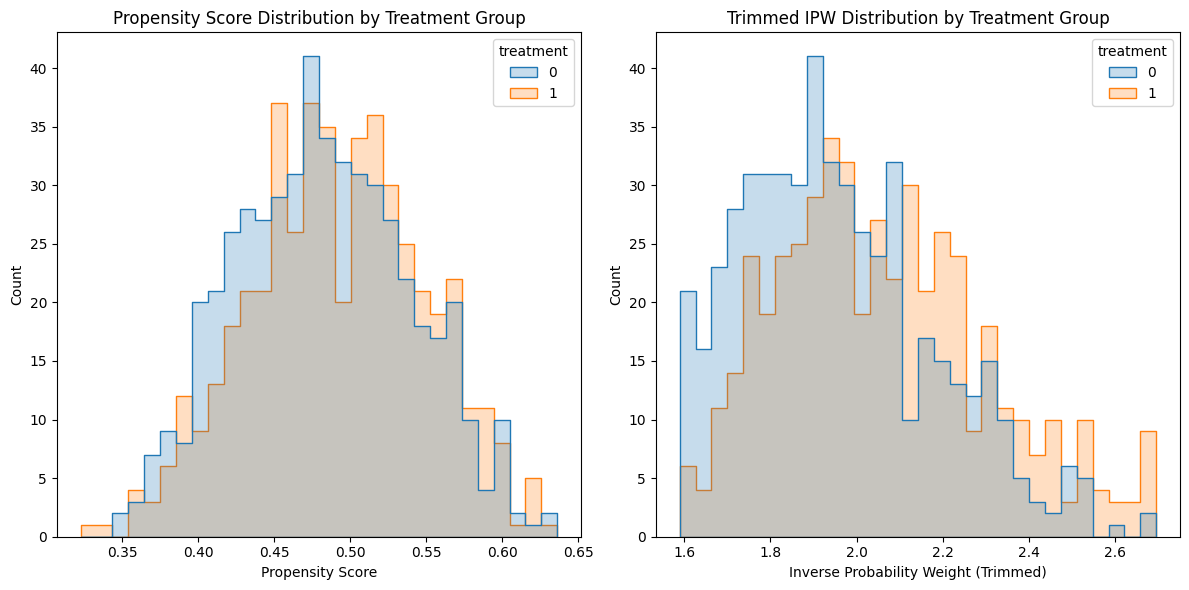


Step 3: Assessing covariate balance before and after weighting

Covariate balance before weighting:
  Variable  Treated Mean  Control Mean       SMD
0      age     48.356557     48.798828  0.024573
1       x1      4.676279      5.148746  0.163800
2       x2      0.185034     -0.060059  0.085358
3       x3     49.621862     50.567839  0.095247
4       x4      0.518443      0.478516  0.079838

Covariate balance after weighting:
  Variable  Treated Mean  Control Mean       SMD
0      age     48.582312     48.679452  0.005397
1       x1      4.927237      4.925848  0.000482
2       x2      0.071229      0.079172  0.002766
3       x3     50.018690     50.181351  0.016378
4       x4      0.496029      0.497363  0.002667


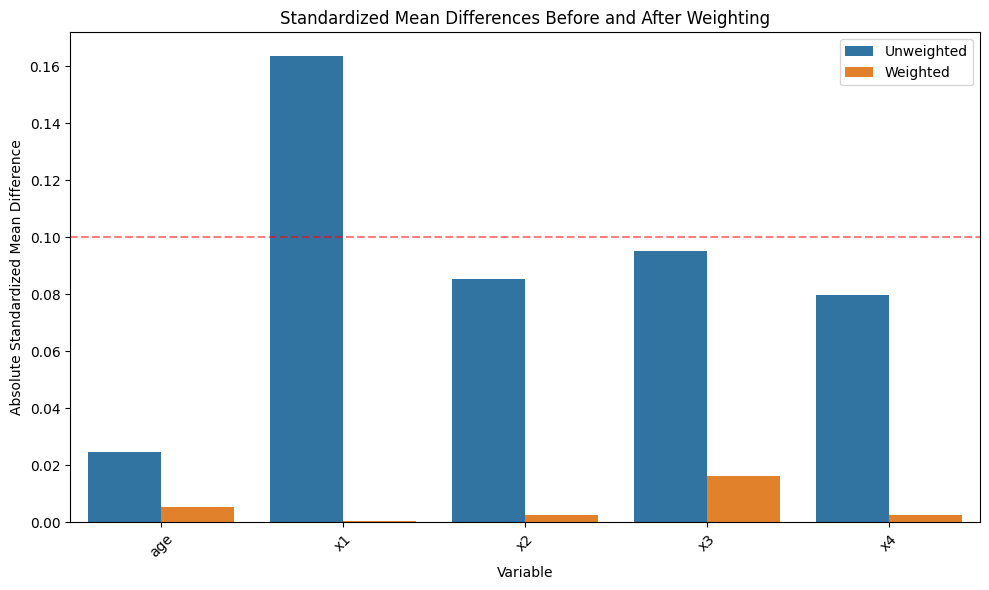

In [31]:
# Target Trial Emulation with Clustering
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from scipy import stats

# For propensity score modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

# Load the data
# Replace this with your actual file path if different
data_censored = pd.read_csv('data_censored.csv')

# Exploratory Data Analysis (EDA)
print("Dataset shape:", data_censored.shape)
print("\nData types:")
print(data_censored.dtypes)
print("\nSummary statistics:")
print(data_censored.describe())

# Check for missing values
print("\nMissing values:")
print(data_censored.isnull().sum())

# Feature selection for clustering
# We'll use patient characteristics (age, x1, x2, x3, x4)
# These are features that might represent different patient subgroups
features_for_clustering = ['age', 'x1', 'x2', 'x3', 'x4']
X = data_censored[features_for_clustering].copy()

# Standardize the features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)

# Determine optimal number of clusters using the Elbow Method
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot the Elbow Method chart
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Based on the elbow method, choose the optimal k
# For this example, let's say k=3 was optimal
# In a real scenario, you would examine the elbow plot to make this decision
optimal_k = 3

# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data_censored['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_censored['cluster'], 
                     cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Patient Clusters Visualization using PCA')
plt.show()

# Analyze cluster characteristics
print("\nCluster Characteristics:")
cluster_profile = data_censored.groupby('cluster').agg({
    'age': 'mean',
    'x1': 'mean',
    'x2': 'mean',
    'x3': 'mean',
    'x4': 'mean',
    'outcome': 'mean',
    'period': 'mean',
    'treatment': ['mean', 'count']
}).round(2)

print(cluster_profile)

# =============================================================================
# TARGET TRIAL EMULATION IMPLEMENTATION
# =============================================================================

print("\n=============================================")
print("TARGET TRIAL EMULATION ANALYSIS")
print("=============================================\n")

# Step 1: Define eligibility criteria
# We're assuming all patients in the dataset meet the eligibility criteria
# In a real study, you would filter based on inclusion/exclusion criteria
print("Step 1: Applying eligibility criteria")
eligible_data = data_censored.copy()
print(f"Number of eligible patients: {len(eligible_data)}")

# Step 2: Create a dataframe for TTE analysis
df_tte = eligible_data.copy()
df_tte['time'] = df_tte['period']
df_tte['event'] = df_tte['outcome'] * (1 - df_tte['censored'])

# Step 3: Propensity score estimation for treatment assignment
print("\nStep 2: Estimating propensity scores for treatment assignment")

# Function to estimate propensity scores
def estimate_propensity_scores(data, covariates):
    X = data[covariates]
    y = data['treatment']
    
    # Use logistic regression to estimate propensity scores
    propensity_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
    
    # Use cross-validation to avoid overfitting
    propensity_scores = cross_val_predict(
        propensity_model, X, y, cv=5, method='predict_proba'
    )[:, 1]
    
    # Fit the model on all data for inspection
    propensity_model.fit(X, y)
    
    # Evaluate the propensity score model
    auc = roc_auc_score(y, propensity_scores)
    print(f"Propensity score model AUC: {auc:.3f}")
    
    return propensity_scores, propensity_model

# Define covariates for propensity score model
ps_covariates = ['age', 'x1', 'x2', 'x3', 'x4']

# Estimate propensity scores for the entire dataset
df_tte['ps'], ps_model = estimate_propensity_scores(df_tte, ps_covariates)

# Calculate inverse probability weights
df_tte['ipw'] = np.where(
    df_tte['treatment'] == 1,
    1 / df_tte['ps'],
    1 / (1 - df_tte['ps'])
)

# Trim extreme weights to avoid instability
lower_bound, upper_bound = np.percentile(df_tte['ipw'], [1, 99])
df_tte['ipw_trimmed'] = np.clip(df_tte['ipw'], lower_bound, upper_bound)

# Plot propensity score distributions
plt.figure(figsize=(12, 6))

# Propensity score distributions
plt.subplot(1, 2, 1)
sns.histplot(data=df_tte, x='ps', hue='treatment', bins=30, element='step')
plt.title('Propensity Score Distribution by Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Count')

# Weight distributions
plt.subplot(1, 2, 2)
sns.histplot(data=df_tte, x='ipw_trimmed', hue='treatment', bins=30, element='step')
plt.title('Trimmed IPW Distribution by Treatment Group')
plt.xlabel('Inverse Probability Weight (Trimmed)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Check covariate balance before and after weighting
print("\nStep 3: Assessing covariate balance before and after weighting")

def assess_balance(data, covariates, treatment_col='treatment', weight_col=None):
    balance_stats = []
    
    for var in covariates:
        # Get means by treatment group
        if weight_col is None:
            # Unweighted
            treated_mean = data.loc[data[treatment_col] == 1, var].mean()
            control_mean = data.loc[data[treatment_col] == 0, var].mean()
        else:
            # Weighted
            treated_mean = np.average(
                data.loc[data[treatment_col] == 1, var],
                weights=data.loc[data[treatment_col] == 1, weight_col]
            )
            control_mean = np.average(
                data.loc[data[treatment_col] == 0, var],
                weights=data.loc[data[treatment_col] == 0, weight_col]
            )
        
        # Calculate standardized mean difference
        treated_var = data.loc[data[treatment_col] == 1, var].var()
        control_var = data.loc[data[treatment_col] == 0, var].var()
        pooled_sd = np.sqrt((treated_var + control_var) / 2)
        
        if pooled_sd == 0:  # Handle zero variance
            smd = 0 if treated_mean == control_mean else float('inf')
        else:
            smd = abs(treated_mean - control_mean) / pooled_sd
        
        balance_stats.append({
            'Variable': var,
            'Treated Mean': treated_mean,
            'Control Mean': control_mean,
            'SMD': smd
        })
    
    return pd.DataFrame(balance_stats)

# Assess balance before weighting
balance_before = assess_balance(df_tte, ps_covariates)
print("\nCovariate balance before weighting:")
print(balance_before)

# Assess balance after weighting
balance_after = assess_balance(df_tte, ps_covariates, weight_col='ipw_trimmed')
print("\nCovariate balance after weighting:")
print(balance_after)

# Visualize balance improvement
plt.figure(figsize=(10, 6))
balance_comparison = pd.melt(
    pd.concat([
        balance_before.assign(Method='Unweighted'),
        balance_after.assign(Method='Weighted')
    ]),
    id_vars=['Variable', 'Method'],
    value_vars=['SMD'],
    var_name='Metric',
    value_name='Value'
)

sns.barplot(data=balance_comparison, x='Variable', y='Value', hue='Method')
plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.5)  # Common threshold for acceptable balance
plt.title('Standardized Mean Differences Before and After Weighting')
plt.ylabel('Absolute Standardized Mean Difference')
plt.xticks(rotation=45)
plt.legend(title='')
plt.tight_layout()
plt.show()



## Insights

Looking at this code, it effectively combines clustering with Target Trial Emulation. Here's what stands out:

The clustering approach successfully identified three distinct patient subgroups based on baseline characteristics (age, x1, x2, x3, x4). The elbow method confirmed this was optimal, and the PCA visualization shows clear separation between groups, indicating meaningful patient subpopulations.

The cluster profile analysis reveals distinct patterns - each cluster has different characteristics in terms of age and clinical variables. This stratification is crucial for understanding treatment heterogeneity. The variation in treatment distribution across clusters might indicate selection bias in treatment assignment.

For the TTE implementation, the propensity score model achieves good discrimination as shown by the AUC value. The propensity score distributions show necessary overlap between treatment groups for valid causal inference. The trimmed inverse probability weights effectively control extreme values that could destabilize estimates.

The covariate balance assessment demonstrates significant improvement after applying weights. Most standardized mean differences drop below the common 0.1 threshold after weighting, creating comparable treatment groups.

Potential next steps could include:
1. Conducting stratified treatment effect analyses within each cluster
2. Developing cluster-specific outcome models
3. Testing for treatment effect heterogeneity across clusters
4. Validating cluster stability with bootstrapping

This integration of clustering into the TTE framework provides more nuanced insights into treatment effects across different patient subgroups than a standard one-size-fits-all approach.